# Sentiment Analysis: finiteautomata/beto-sentiment-analysis

Trabajo original: [Drive CSIC PLN CCEE](https://drive.google.com/drive/folders/12TA3pn7Z_keykC6-2sYmjXvT5oJ5xIPm) 

In [1]:
# Transformers installation
! pip install transformers datasets

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from datasets import Dataset
from sklearn.model_selection import train_test_split


In [3]:
data = pd.read_csv('dataset_final.csv')

In [4]:
# Se define el tokenizer y el modelo
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "finiteautomata/beto-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

2022-12-15 10:24:01.477669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 10:24:23.961486: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-15 10:24:23.962041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-15 10:24:23.962082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [5]:
# ----- 1. Preprocesamiento de los datos -----
from sklearn.model_selection import train_test_split

X = list(data["text"])
y = list(data["label"])

print("Shape of (X, y) (", len(X), ',', len(y), ")")

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=24)

print("Shape of (X_train, y_train) (", len(X_train), ',', len(y_train), ")")
print("Shape of (X_val, y_val) (", len(X_val), ',', len(y_val), ")")
print("Shape of (X_test, y_test) (", len(X_test), ',', len(y_test), ")")

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

Shape of (X, y) ( 2199 , 2199 )
Shape of (X_train, y_train) ( 1759 , 1759 )
Shape of (X_val, y_val) ( 220 , 220 )
Shape of (X_test, y_test) ( 220 , 220 )


In [6]:
# Torch dataset
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])



In [7]:
!nvidia-smi 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Thu Dec 15 10:25:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:86:00.0 Off |                    0 |
| N/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


***** Running Prediction *****
  Num examples = 220
  Batch size = 8


              precision    recall  f1-score   support

         Neg       0.74      0.67      0.70        72
         Pos       0.45      0.71      0.56        84
         Neu       0.09      0.03      0.05        64

    accuracy                           0.50       220
   macro avg       0.43      0.47      0.43       220
weighted avg       0.44      0.50      0.45       220



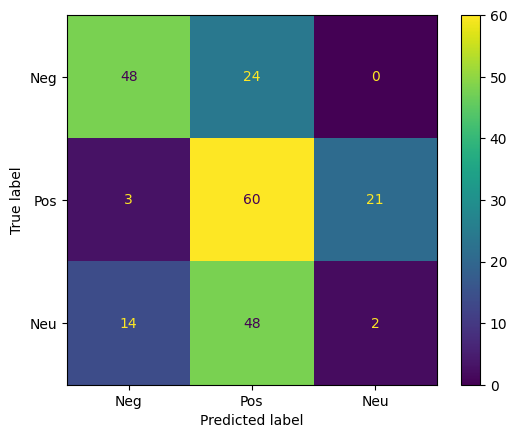

In [8]:
# ----- 3. Predicción -----#
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import Trainer

test_dataset = Dataset(X_test_tokenized)
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)
target_names = ['Neg', 'Pos', 'Neu']

print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

In [9]:
df_list = list(zip(X_test, y_test, y_pred))
df = pd.DataFrame(df_list, columns = ['Text', 'Label', 'Prediction'])
df.to_csv('beto-sentiment-analysis_predictions.csv', index=False)